# CheXpert Supervised Learning GradCAM Operation
这里我们给出用`Densenet`在`CheXpert`数据集上训练的过程中得到梯度因子激活映射的热力图的代码，以胸部积液(Pleural Effusion)为例

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.autograd import Function
import importlib
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "3"

def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function

class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(
            torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output
    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            torch.addcmul(
                torch.zeros(input.size()).type_as(input), grad_output,
                positive_mask_1), positive_mask_2)

        return grad_input,None


class GBReLU(nn.Module):
    def __init__(self, inplace=True):
        super(GBReLU, self).__init__()

    def forward(self, input):
        output = GuidedBackpropReLU.apply(input)
        return output

class _PreProcess(nn.Sequential):
    def __init__(self, num_input_channels, num_init_features=16, small_input=True):
        super(_PreProcess, self).__init__()
        if small_input:
            self.add_module('conv0',
                            nn.Conv2d(num_input_channels, num_init_features, kernel_size=3, stride=1, padding=1,
                                      bias=True))
        else:
            self.add_module('conv0',
                            nn.Conv2d(num_input_channels, num_init_features, kernel_size=7, stride=2, padding=3,
                                      bias=True))
            self.add_module('norm0', nn.BatchNorm2d(num_init_features))
            self.add_module('relu0', nn.ReLU(inplace=True))
            self.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False))


class _Classify(nn.Sequential):
    def __init__(self, num_input_channels, num_classes):
        super(_Classify, self).__init__()
        self.add_module('fc',
                        nn.Linear(num_input_channels, num_classes))
        self.add_module('log_softmax', nn.LogSoftmax(dim=1))


class _DenseLayer2D(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, efficient=False):
        super(_DenseLayer2D, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate
        self.efficient = efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _Transition2D(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition2D, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class _DenseBlock2D(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, efficient=False):
        super(_DenseBlock2D, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer2D(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class MultiLabelDenseNet(nn.Module):

    def __init__(self, num_input_channels=1, growth_rate=32, block_config=(6, 12, 24, 16),
                 compression=0.5, num_init_features=16, bn_size=4, drop_rate=float(0), efficient=False,
                 class_config=(2, 2, 2, 2, 2), data_parallel=True, small_input=False):
        super(MultiLabelDenseNet, self).__init__()
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'
        # First convolution
        self.encoder = nn.Sequential()
        self.classify = nn.Sequential()
        self._block_config = block_config
        self._class_config = class_config
        pre_process = _PreProcess(num_input_channels, num_init_features, small_input=small_input)
        if data_parallel:
            pre_process = nn.DataParallel(pre_process)
        self.encoder.add_module("pre_process", pre_process)
        # add dense block
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock2D(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            if data_parallel:
                block = nn.DataParallel(block)
            self.encoder.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition2D(num_input_features=num_features,
                                      num_output_features=int(num_features * compression))
                if data_parallel:
                    trans = nn.DataParallel(trans)
                self.encoder.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)
            else:
                trans = nn.Sequential()
                trans.add_module("norm", nn.BatchNorm2d(num_features))
                trans.add_module("relu", nn.ReLU(num_features))                
                if data_parallel:
                    trans = nn.DataParallel(trans)
                self.encoder.add_module('transition%d' % (i + 1), trans)
        global_avg = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        if data_parallel:
            global_avg = nn.DataParallel(global_avg)
        self.global_avg = global_avg
        for i, class_cfg in enumerate(self._class_config):
            cls = _Classify(num_input_channels=num_features, num_classes=class_cfg)
            if data_parallel:
                cls = nn.DataParallel(cls)
            self.classify.add_module('classify%d' % (i + 1), cls)
        # Initialization (by xavier)
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'fc' in name and 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'fc' in name and 'bias' in name:
                param.data.fill_(0)

    def forward(self, input_img):
        batch_size = input_img.size(0)
        feature = self.encoder(input_img)
        gap_feature = self.global_avg(feature).view(batch_size, -1)
        prediction_list = []
        for i, class_cfg in enumerate(self._class_config):
            output = getattr(self.classify, 'classify%d' % (i + 1))(gap_feature)
            prediction_list.append(output)
        return prediction_list

    def gcam_calculation(self, input_img):
        batch_size = input_img.size(0)
        feature = self.encoder(input_img)
        feature.retain_grad()
        gap_feature = self.global_avg(feature).view(batch_size, -1)
        prediction_list = []
        for i, class_cfg in enumerate(self._class_config):
            output = getattr(self.classify, 'classify%d' % (i + 1))(gap_feature)
            prediction_list.append(output)
        return prediction_list, feature


densenet_dict = {
    "densenet121": {"growth_rate": 32, "block_config": (6, 12, 24, 16), "num_init_features": 64},
    "densenet161": {"growth_rate": 48, "block_config": (6, 12, 36, 24), "num_init_features": 96},
    "densenet169": {"growth_rate": 32, "block_config": (6, 12, 32, 32), "num_init_features": 64},
    "densenet201": {"growth_rate": 32, "block_config": (6, 12, 48, 32), "num_init_features": 64},
    "densenetbc100": {"growth_rate": 12, "block_config": (16, 16, 16), "num_init_features": 24},
    "densenetbc250": {"growth_rate": 24, "block_config": (41, 41, 41), "num_init_features": 48},
    "densenetbc190": {"growth_rate": 40, "block_config": (31, 31, 31), "num_init_features": 40}
}


def get_multi_label_densenet(name, drop_rate, data_parallel, class_config):
    return MultiLabelDenseNet(growth_rate=densenet_dict[name]["growth_rate"],
                              block_config=densenet_dict[name]["block_config"],
                              num_init_features=densenet_dict[name]["num_init_features"],
                              drop_rate=drop_rate, data_parallel=data_parallel, class_config=class_config)


In [15]:
class CheXpertGradCAM(nn.Module):
    def __init__(self, resume_path):
        if os.path.isfile(resume_path):
            checkpoint = torch.load(resume_path)
        else:
            raise FileNotFoundError("{} not found".format(resume_path))
        args = checkpoint['args']
        super(CheXpertGradCAM,self).__init__()
        print("change relu to GBReLU")
        nn.ReLU = GBReLU
        self.model= get_multi_label_densenet(args.net_name, drop_rate=args.dr, data_parallel=args.dp,
                                         class_config=(2,2,2,2,2))
        self.model.load_state_dict(checkpoint["state_dict"])
        self.model.cuda()
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
        print("change back")
        importlib.reload(nn)
    def get_gradcam(self,image,classify_index):
        """
        image: 1*1*h*w cuda tensor with preprocessed
        return: Grad Class Activation Map,Grad in raw image
        """
        image.requires_grad = True
        if image.grad is not None:
            image.grad.data.zero_()
        classify_result_list,feature= self.model.gcam_calculation(image)
        classify_result = torch.softmax(classify_result_list[classify_index],dim=1)
        loss = classify_result[0,1]
        print("The score for class {} is {}".format(classify_index,loss))
        loss.backward()
        thermo_grad = feature.grad.detach()
        image_grad = image.grad.detach()
        # generate class activation map
        image_grad = F.relu(image_grad,inplace=True)
        thermo_weight = F.adaptive_avg_pool2d(thermo_grad,(1,1))
        thermo = thermo_weight * feature.detach()
        thermo = nn.functional.relu(torch.sum(thermo,dim = 1,keepdim = True),inplace=True)
        thermo = nn.functional.interpolate(thermo,size = (image.size(2),image.size(3)),mode="bilinear",align_corners=True)
        # clear grad
        feature.grad.data.zero_()
        return loss,thermo.detach().cpu().squeeze().numpy(),image_grad.detach().cpu().squeeze().numpy()
    def get_pixel_weight_gradcam(self,image,classify_index):
        """
        image: 1*1*h*w cuda tensor with preprocessed
        return: Grad Class Activation Map,Grad in raw image
        """
        image.requires_grad = True
        if image.grad is not None:
            image.grad.data.zero_()
        classify_result_list,feature= self.model.gcam_calculation(image)
        classify_result = torch.softmax(classify_result_list[classify_index],dim=1)
        loss = classify_result[0,1]
        print("The score for class {} is {}".format(classify_index,loss))
        loss.backward()
        thermo_grad = feature.grad.detach()
        image_grad = image.grad.detach()
        # generate class activation map
        image_grad = F.relu(image_grad,inplace=True)
        thermo_grad = F.relu(thermo_grad,inplace=True)
        thermo = thermo_grad * feature.detach()
        thermo = nn.functional.relu(torch.sum(thermo,dim = 1,keepdim = True),inplace=True)
        thermo = nn.functional.interpolate(thermo,size = (image.size(2),image.size(3)),mode="bilinear",align_corners=True)
        # clear grad
        feature.grad.data.zero_()
        return loss,thermo.detach().cpu().squeeze().numpy(),image_grad.detach().cpu().squeeze().numpy()

## Example

In [16]:
import os
from os import path
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pylab import subplots_adjust
import numpy as np
from torchvision import transforms

In [17]:
img=Image.open(path.join("/data/fhz","dataset",'CheXpert','CheXpert-v1.0-small/train/patient00008/study1/view1_frontal.jpg'))
transform = transforms.Compose([
    transforms.Resize((320,384)),
    transforms.ToTensor()
])
img_tensor = transform(img).unsqueeze(0).float()
img_tensor = img_tensor.cuda()

In [18]:
chexpert_gcam = CheXpertGradCAM(resume_path="/data/fhz/CheXpert/parameter/train_time:2/checkpoint.pth.tar")

change relu to GBReLU
change back


In [19]:
loss,gcam,img_grad = chexpert_gcam.get_gradcam(img_tensor,4)
loss,gcam_pixel,img_grad_pixel = chexpert_gcam.get_pixel_weight_gradcam(img_tensor,4)

The score for class 4 is 0.8790804147720337
The score for class 4 is 0.8790804147720337


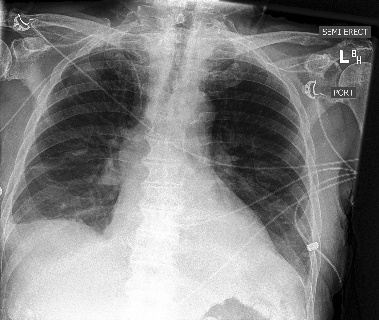

In [20]:
img

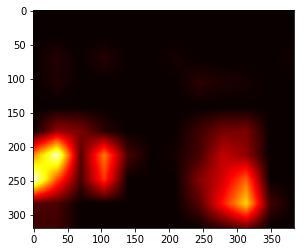

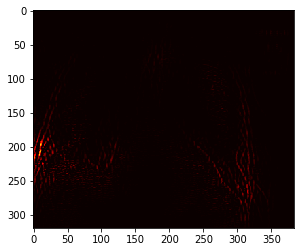

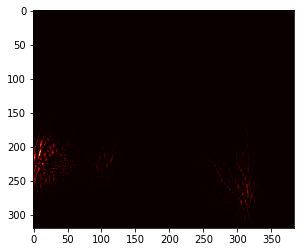

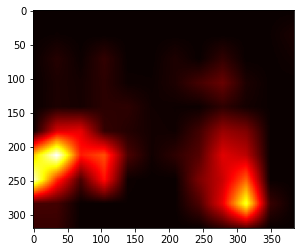

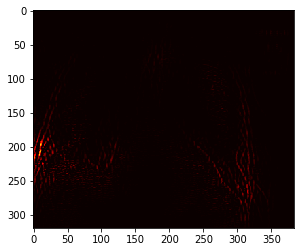

In [22]:
plt.imshow(gcam,cmap = "hot")
plt.show()
plt.imshow(img_grad,cmap = "hot")
plt.show()
plt.imshow(gcam*img_grad,cmap = "hot")
plt.show()
plt.imshow(gcam_pixel,cmap = "hot")
plt.show()
plt.imshow(img_grad_pixel,cmap = "hot")
plt.show()